# 1. Loading of packages and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from matplotlib.pyplot import figure

In [2]:
dfs = pd.read_csv("Data_Assignment_1.csv")

In [3]:
dfs['year_month'] = dfs['month'].map(str) + " " + dfs['year'].map(str)
dfs['year_month'] = pd.to_datetime(dfs['year_month'])
newdfs = dfs[['year_month','num_transactions']]
newdfs.index = newdfs['year_month']
del newdfs['year_month']
newdfs.head()

,num_transactions
year_month,
2000-01-01,1718
2000-02-01,1597
2000-03-01,1701
2000-04-01,1549
2000-05-01,1578


# 2. Model Identification

## 2.1. Plot graph, ACF and PACF

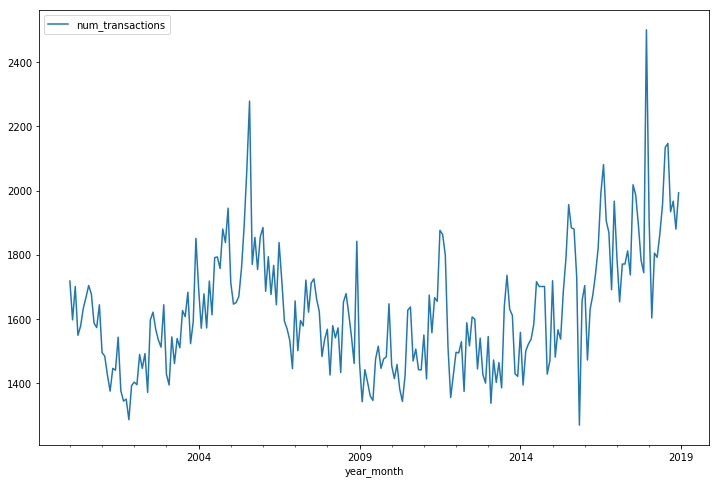

In [4]:
# Visualise our data
newdfs.plot(figsize=(12,8))

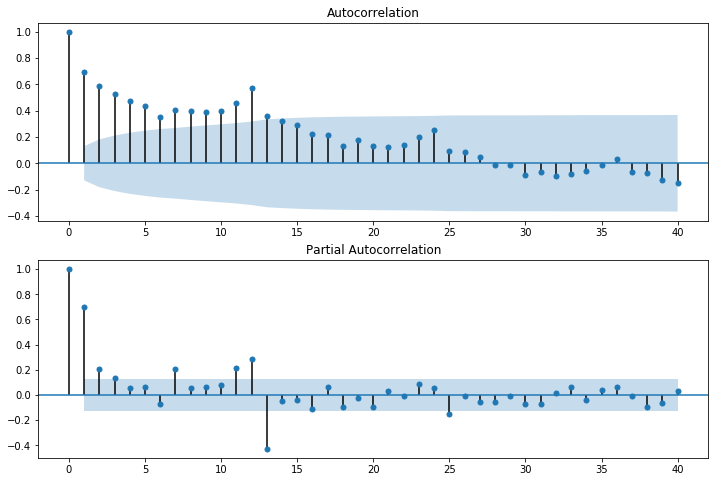

In [5]:
# Plot ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211) #2 by 1, first subplot
fig = sm.graphics.tsa.plot_acf(newdfs, lags=40, ax=ax1) #Plot acf
ax2 = fig.add_subplot(212) #2 by 1, second subplot
fig = sm.graphics.tsa.plot_pacf(newdfs, lags=40, ax=ax2) #Plot PACF

- From the plots of ACF and PACF, we realise that there seems to be a seasonal and a downward sloping pattern in the ACF plot. Hence, we shall explore the stationarity properties of this time series in the following section.
- There also seem to be a cut off point at lag=2 from the PACF. This data could have an AR(2) property.

## 2.2. Check for stationarity

### 2.2.1 Decomposition method

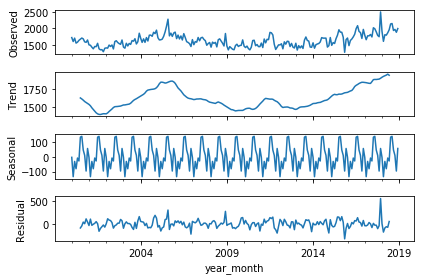

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Used additive instead of multiplicative as original value did not show a huge increase
result = seasonal_decompose(newdfs, model="additive") 
fig = result.plot()

We can clearly see that there exist an increaseing trend and a seasonal effect.

### 2.2.2 ADFuller test method

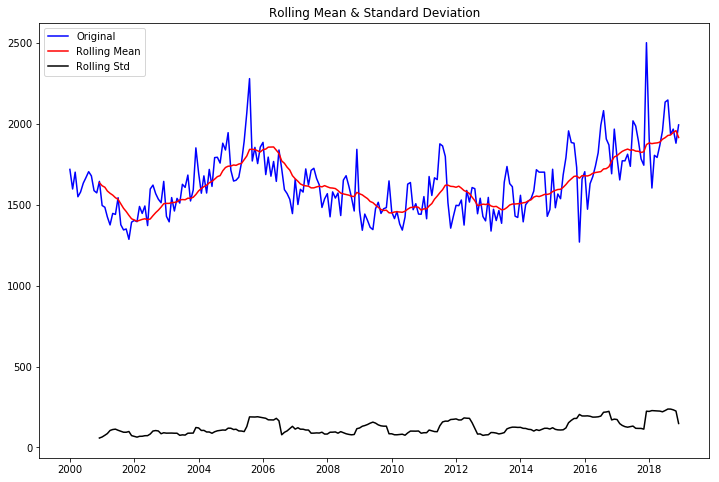

Results of Dickey-Fuller Test:
Test Statistic                  -1.314244
p-value                          0.622631
#Lags Used                      12.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    figure(figsize=(12,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries["num_transactions"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(newdfs)

- Since p-value is large, we do not reject the null hypothesis that there exist a unit root and thus is non-stationary.
- Test statistic > critical value at 0.01,0.05 and 0.1
- The mean is increasing even though the standard deviation is very low. As such there exist a trend which is not due to the effects of standard deviation.

## 2.3. Apply first differencing

### 2.3.1 First differencing to remove trend

In [8]:
first_df_newdfs = newdfs.diff(axis=0,periods = 1)
first_df_newdfs = first_df_newdfs[1:] # Remove null value
first_df_newdfs.head()

,num_transactions
year_month,
2000-02-01,-121.0
2000-03-01,104.0
2000-04-01,-152.0
2000-05-01,29.0
2000-06-01,55.0


### 2.3.2 Check for stationarity with decomposition

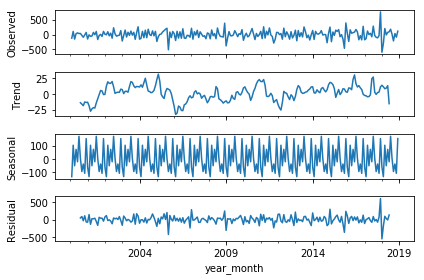

In [9]:
#Used additive instead of multiplicative as original value did not show a huge increase
results = seasonal_decompose(first_df_newdfs, model='additive') 
fig = results.plot()

We can observe that now the trend is removed. However, there is still a clear seasonal pattern in the decomposition.

### 2.3.3 Check for stationarity with adfuller test

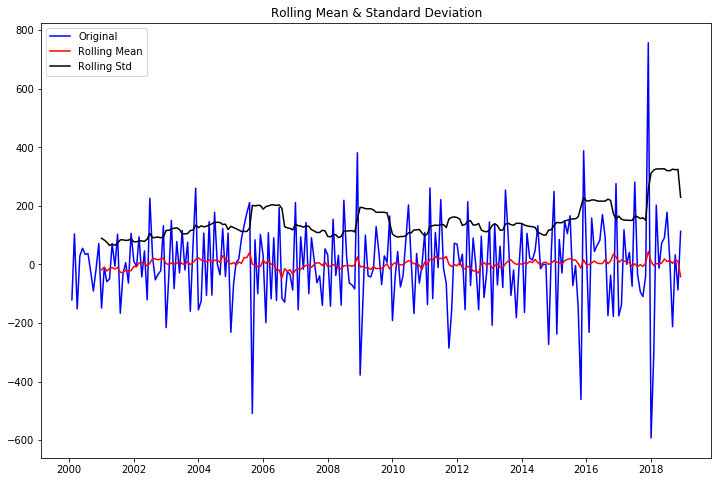

Results of Dickey-Fuller Test:
Test Statistic                  -5.451218
p-value                          0.000003
#Lags Used                      11.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


In [10]:
test_stationarity(first_df_newdfs)

ADF test seems to tell us that the time series is stationary (p-value is low -> null-hypothesis rejected -> time series is stationary). However, ADF test is tailored for detecting nonstationarity in the form of a unit root test. It is NOT tailored to detect other forms of nonstationarity. As such, it is unable to detect nonstationarity of the seasonal kind. As such, this test only tells us that the trend component is removed. However the seasonality component is not removed as supported by the decomposition plot in 2.3.2.

# 3. Model estimation

<b>How do we continue from here?</b><br>
From the above tests and plots, we are sure that there exist both trend and seasonality in the data. As such, we shall be building 2 type of models (ARIMA and SARIMAX). In this section, we will be trying to estimate the order of the models to use using visuals and selection criterion and grid search. Afterwards in section 4, we will diagnose our models to select the best underlying data structure of the given data series.

## 3.2 ARIMA

In [11]:
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings; warnings.simplefilter('ignore')

p = range(2,3) # We set p to 2 as be believe there is an AR(2) component in our time series.
d = range(1,2) # We set our lags to be 1 to account for the trend component in our time series.
q = range(0, 6) # We are trying to discover the lags to be used for MA component as it wasn't clear from the ACF and PACF plots.
pdq = list(itertools.product(p, d, q))

# To record the best model
best_aic = np.inf
best_bic = np.inf
best_model = None

for param in pdq:
    try:
        mod = ARIMA(newdfs,order = param)
        results = mod.fit()
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = mod
        if results.bic < best_bic:
            best_bic = results.bic
            best_model = mod
            
        print('ARIMA{} - AIC:{}; BIC:{}'.format(param, results.aic,results.bic))
    except:
        continue

ARIMA(2, 1, 0) - AIC:2885.1418580455916; BIC:2898.841658115517
ARIMA(2, 1, 1) - AIC:2867.7149443221183; BIC:2884.8396944095252
ARIMA(2, 1, 2) - AIC:2869.2717278448035; BIC:2889.821427949692
ARIMA(2, 1, 3) - AIC:2870.496223063785; BIC:2894.4708731861547
ARIMA(2, 1, 4) - AIC:2844.8143857399596; BIC:2872.213985879811
ARIMA(2, 1, 5) - AIC:2845.910506826493; BIC:2876.7350569838254


In [12]:
results = best_model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.num_transactions   No. Observations:                  227
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1414.407
Method:                       css-mle   S.D. of innovations            121.229
Date:                Fri, 01 Mar 2019   AIC                           2844.814
Time:                        17:11:06   BIC                           2872.214
Sample:                    02-01-2000   HQIC                          2855.871
                         - 12-01-2018                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.4078      2.255      0.624      0.533      -3.011       5.827
ar.L1.D.num_transactions    -1.7312      0.002   -716.910      0.000      -1.736      -1.

From the grid search of ARIMA, we found the best model to be ARIMA(2,1,4). We will explore the residuals in section 4

## 3.2 SARIMAX

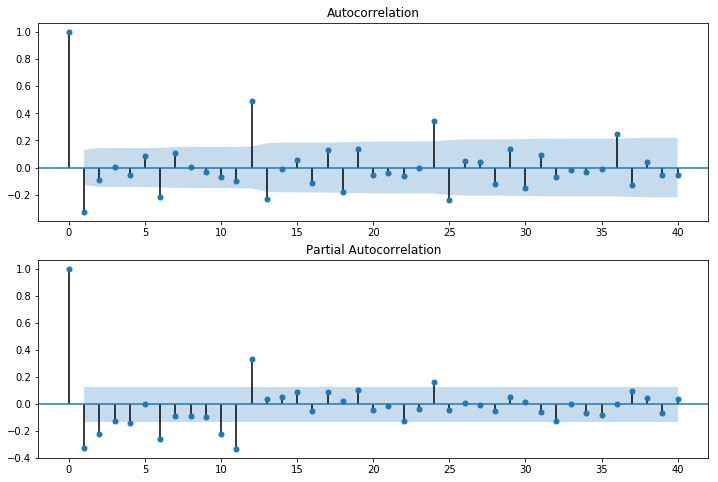

In [13]:
# Plot ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211) #2 by 1, first subplot
fig = sm.graphics.tsa.plot_acf(first_df_newdfs, lags=40, ax=ax1) #Plot acf
ax2 = fig.add_subplot(212) #2 by 1, second subplot
fig = sm.graphics.tsa.plot_pacf(first_df_newdfs, lags=40, ax=ax2) #Plot PACF

- We observe that there are spikes at lag 12,24,36... As such, we have a reason to believe that we should fit our SARIMAX model with a seasonality of 12.<br>
- ACF: There seem to be a cut off point at q = 1 <br>
- PACF: There seem to be a cut off point at p = 2 <br>
- We will still conduct a grid search to find out the best seasonal P and seasonal Q.


In [14]:
import itertools
import warnings; warnings.simplefilter('ignore')

p = range(0,6) # Grid search for P
d = range(1,2) # D set to 1 due to stable seasonality
q = range(0, 6) # Grid search for Q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_bic = np.inf
best_model = None
for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(newdfs,
                                        order=(2,1,1),
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = mod
        if results.bic < best_bic:
            best_bic = results.bic
            best_model = mod
        print('ARIMA{}x{}12 - AIC:{}; BIC:{}'.format((2,1,1), param_seasonal, results.aic,results.bic))
    except:
        continue

ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:2683.601988617499; BIC:2697.0471572803367
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:2474.3871186910883; BIC:2490.9036432313837
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:2327.947747704087; BIC:2347.398229794445
ARIMA(2, 1, 1)x(0, 1, 3, 12)12 - AIC:2189.2926593635857; BIC:2211.5257074916026
ARIMA(2, 1, 1)x(0, 1, 4, 12)12 - AIC:2048.3204230947067; BIC:2073.167986885911
ARIMA(2, 1, 1)x(0, 1, 5, 12)12 - AIC:4921.366421452078; BIC:4948.64036274461
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:2511.5911219435684; BIC:2528.107646483864
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:2473.566192926458; BIC:2493.3860223748125
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:2329.624377831956; BIC:2352.3166069373733
ARIMA(2, 1, 1)x(1, 1, 3, 12)12 - AIC:2188.878057374691; BIC:2214.2872552352815
ARIMA(2, 1, 1)x(1, 1, 4, 12)12 - AIC:2048.609158997027; BIC:2076.5626682621323
ARIMA(2, 1, 1)x(1, 1, 5, 12)12 - AIC:6061.769054799138; BIC:6092.073434013062
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:2358.387996683066

In [15]:
results = best_model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                   num_transactions   No. Observations:                  228
Model:             SARIMAX(2, 1, 1)x(5, 1, 3, 12)   Log Likelihood                -932.223
Date:                            Fri, 01 Mar 2019   AIC                           1888.445
Time:                                    17:19:22   BIC                           1924.810
Sample:                                01-01-2000   HQIC                          1903.217
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1636      0.154      1.062      0.288      -0.138       0.466
ar.L2         -0.1037      0.118   

From the grid search of SARIMAX, we found the best model to be SARIMAX(2,1,2)x(5,1,3,12). We will explore the residuals in section 4

# 4. Model Diagnostic

## 4.1. Analysis of model statistics

### 4.1.1. ARIMA

In [16]:
#ARIMA
mod_ARIMA = sm.tsa.statespace.SARIMAX(newdfs,
                                        order=(2,1,4),
                                        seasonal_order=(0,0,0,0),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_ARIMA = mod_ARIMA.fit()
print(results_ARIMA.summary())

                           Statespace Model Results                           
Dep. Variable:       num_transactions   No. Observations:                  228
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -1386.786
Date:                Fri, 01 Mar 2019   AIC                           2787.572
Time:                        17:19:22   BIC                           2811.391
Sample:                    01-01-2000   HQIC                          2797.189
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7341      0.010   -172.503      0.000      -1.754      -1.714
ar.L2         -1.0031      0.012    -86.229      0.000      -1.026      -0.980
ma.L1          1.3484      0.079     17.176      0.0

Absolute values of ar.L1, ar.L2 and ma.L1 is larger than 1  which violates the unit root theorem. If coefficients are more than 1, the coefficients will not be invertible.

### 4.1.2. SARIMAX

In [17]:
mod_SARIMAX = sm.tsa.statespace.SARIMAX(newdfs,
                                        order=(2,1,1),
                                        seasonal_order=(5,1,3,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_SARIMAX = mod_SARIMAX.fit()
print(results_SARIMAX.summary())

                                 Statespace Model Results                                 
Dep. Variable:                   num_transactions   No. Observations:                  228
Model:             SARIMAX(2, 1, 1)x(5, 1, 3, 12)   Log Likelihood                -932.223
Date:                            Fri, 01 Mar 2019   AIC                           1888.445
Time:                                    17:19:56   BIC                           1924.810
Sample:                                01-01-2000   HQIC                          1903.217
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1636      0.154      1.062      0.288      -0.138       0.466
ar.L2         -0.1037      0.118   

Absolute values of all model parameters from ar.L1 to ma.S.L36 are all less than 1 which is desirable as the coefficients are now invertible which means that the model provides a stationary time series.

## 4.2. Analysis of residual

### 4.2.1. ARIMA

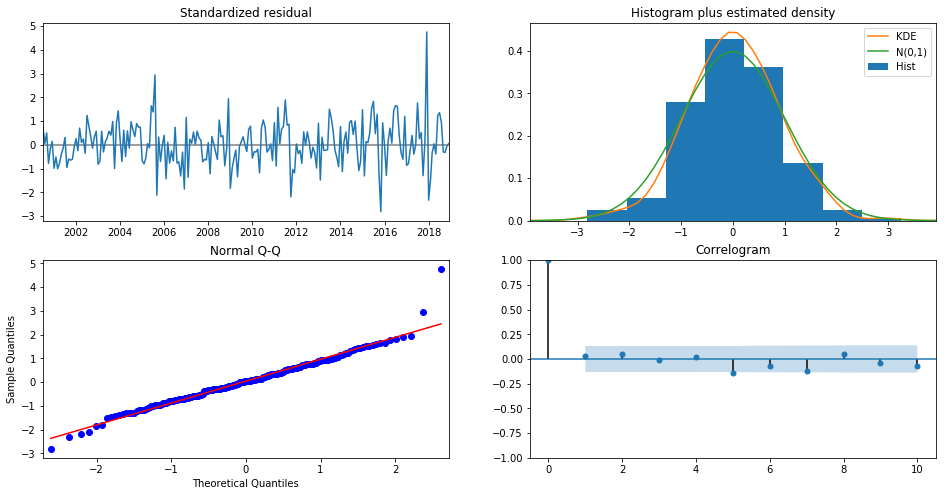

                 0
count   228.000000
mean     19.220766
std     190.319539
min    -371.746049
25%     -79.819679
50%       6.068611
75%      83.656300
max    1718.000000


In [18]:
results_ARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()
residuals = pd.DataFrame(results_ARIMA.resid)
print(residuals.describe())

For the ARIMA model, the mean of residuals deviate largely from 0. As such, the residuals are not normally distributed. There might be lurking variables in the residuals which are not accounted for.

### 4.2.2. SARIMAX 

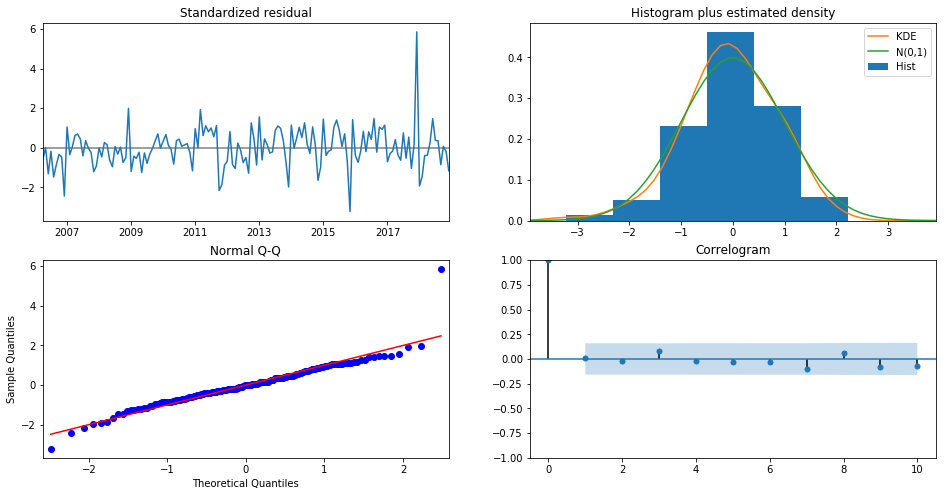

                 0
count   228.000000
mean      2.350754
std     181.672594
min   -1085.376707
25%     -67.172291
50%       1.488197
75%      72.483524
max    1718.000000


In [19]:
results_SARIMAX.plot_diagnostics(figsize=(16, 8))
plt.show()
residuals = pd.DataFrame(results_SARIMAX.resid)
print(residuals.describe())

For our SARIMAX model, the mean is now much closer to 0. This means that our residuals are most likely normally distributed. Even though it is not perfect, it is still a good enough model. We shall analyse the forecast error to further validate our model.

## 4.3. Analysis of forecast errors

In [20]:
# Split into training and testing data
percent_training = 0.7
split_point = round(len(newdfs)*percent_training)
training,testing = newdfs[0:split_point],newdfs[split_point:]

In [21]:
testing.head() # To find start date of prediction

,num_transactions
year_month,
2013-05-01,1464
2013-06-01,1385
2013-07-01,1639
2013-08-01,1736
2013-09-01,1630


In [22]:
testing.tail() # To find end date of prediction

,num_transactions
year_month,
2018-08-01,2147
2018-09-01,1934
2018-10-01,1967
2018-11-01,1880
2018-12-01,1993


### 4.3.1. ARIMA

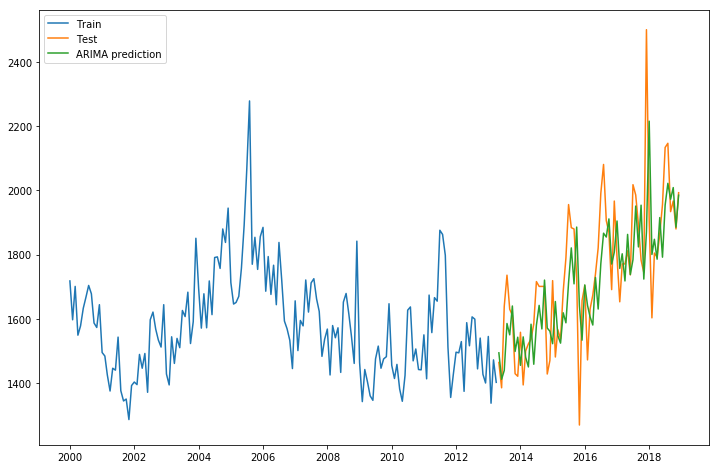

In [23]:
y_hat_avg = testing.copy() # Make a copy of the test data
fit1 = results_ARIMA    # Model that we established earlier
y_hat_avg['ARIMA'] = fit1.predict(start="2013-05-01", end="2018-12-01") # Date determined by start of test and end of test data
plt.figure(figsize=(12,8))
plt.plot(training['num_transactions'], label='Train')
plt.plot(testing['num_transactions'], label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA prediction')
plt.legend(loc='best')
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(testing.num_transactions, y_hat_avg.ARIMA))
print(rms)

150.43518673713368


### 4.3.2. SARIMAX

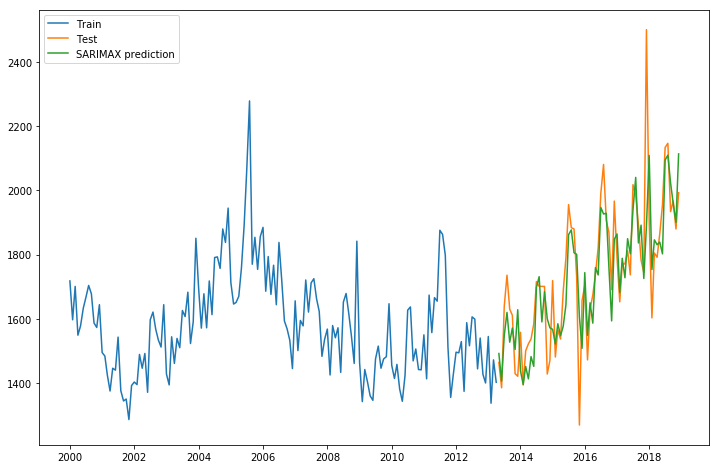

In [25]:
y_hat_avg = testing.copy() # Make a copy of the test data
fit1 = results_SARIMAX     # Model that we established earlier
y_hat_avg['SARIMAX'] = fit1.predict(start="2013-05-01", end="2018-12-01") # Date determined by start of test and end of test data
plt.figure(figsize=(12,8))
plt.plot(training['num_transactions'], label='Train')
plt.plot(testing['num_transactions'], label='Test')
plt.plot(y_hat_avg['SARIMAX'], label='SARIMAX prediction')
plt.legend(loc='best')
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(testing.num_transactions, y_hat_avg.SARIMAX))
print(rms)

122.08437304389766


RMSE of our SARIMAX model is much lower than our ARIMA model. This shows that our SARIMAX model is indeed a better model for forecasting.

# References:
https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000<br>
https://stats.stackexchange.com/questions/225087/seasonal-data-deemed-stationary-by-adf-and-kpss-tests<br>
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b<br>
https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods<br>
https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima